# imports and loading DataFrame

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import numpy as np
import datetime


# fact table
sessions_df = pd.read_json("data/sessions.jsonl", lines=True)

# dimension tables
deliveries_df = pd.read_json("data/deliveries.jsonl", lines=True)
products_df = pd.read_json("data/products.jsonl", lines=True)
users_df = pd.read_json("data/users.jsonl", lines=True)

# constant values

In [2]:
MAKE_PLOTS = False
MAKE_PAIRPLOT = False
DATE_FORMAT = "%Y-%m-%dT%H:%M:%S"
PRICE_TRESHOLD = 100_000    # for outliers
WEIGHT_TRESHOLD = 50        # for outliers
COLUMNS_TO_DROP = ["delivery_timestamp", "session_id", "purchase_id", "event_type", "name", "street", "product_id", "product_name", "brand", "user_id"]
COLUMNS_TO_ONE_HOT = ["delivery_company", "city", "category_path"]
SEED = 42
SHOW_ALL_WARNINGS = False
SHOW_ONLY_ONE_WARNING = False

In [3]:
import warnings

if SHOW_ONLY_ONE_WARNING:
    warnings.filterwarnings(action='once')
elif not SHOW_ALL_WARNINGS:
    warnings.filterwarnings('ignore')

# merging all data into one DataFrame and other transformations

## adding a column with time difference in deliveries
adding a column with time difference between purchase_timestamp and delivery_timestamp in deliveries table

1. Cut microseconds from delivery_timestamp, so it will be the same format as purchase_timestamp, because there are no microseconds in purchase_timestamp (using "." as a separator).
2. Change columns format to datetime
3. Add time_diff column (as timedelta64 object).
4. Drop rows where time_diff is null (which means that delivery_timestamp was null).
5. Change type of time_diff from timedelta64 to seconds in float.
6. Drop rows where time_diff is below 0. THIS STEP IS MADE IN ### without time_diff below 0

In [4]:
# 1.
deliveries_df["delivery_timestamp"] = deliveries_df["delivery_timestamp"].str.split('.', expand=True)[0]

# 2.
deliveries_df["purchase_timestamp"] = pd.to_datetime(deliveries_df["purchase_timestamp"], format=DATE_FORMAT)
deliveries_df["delivery_timestamp"] = pd.to_datetime(deliveries_df["delivery_timestamp"], format=DATE_FORMAT)

# 3.
deliveries_df["time_diff"] = deliveries_df["delivery_timestamp"] - deliveries_df["purchase_timestamp"]

# 4.
deliveries_df = deliveries_df[deliveries_df["time_diff"].notna()]

# 5.
# time diff as duration in seconds
deliveries_df["time_diff"] = deliveries_df["time_diff"].apply(datetime.timedelta.total_seconds)

# 6.
# deliveries_df = deliveries_df[deliveries_df["time_diff"] >= 0]

## join deliveries with sessions

In [5]:
# drop rows where event_type is not equal "BUY_PRODUCT"
sessions_df = sessions_df[sessions_df["event_type"] == "BUY_PRODUCT"]
df = deliveries_df.merge(sessions_df, on="purchase_id", how="left")

In [6]:
# making sure, that timestamp == purchase_timestamp
num_of_rows_before = df.shape[0]
df = df[df["timestamp"] == df["purchase_timestamp"]]
num_of_rows_after = df.shape[0]

assert(num_of_rows_before == num_of_rows_after)

# now we can drop timestamp column, as it is redundant
df = df.drop(columns="timestamp")

## join with other tables

In [7]:
df = df.merge(users_df, on="user_id", how="left")
df = df.merge(products_df, on="product_id", how="left")

# missing data analysis - MCAR, MAR, MNAR

made without outliers but with prices below zero (on copy of df)

In [8]:
missing_data_df = df.copy(deep=False)
missing_data_df["delivery_company_is_missing"] = missing_data_df["delivery_company"].isna()
missing_data_df["user_id_is_missing"] = missing_data_df["user_id"].isna()
missing_data_df["product_id_is_missing"] = missing_data_df["product_id"].isna()

In [9]:
# rejecting outliers for given PRICE_TRESHOLD
missing_data_df = missing_data_df[missing_data_df["price"] <= PRICE_TRESHOLD]

# rejecting outliers for given WEIGHT_TRESHOLD
missing_data_df = missing_data_df[missing_data_df["weight_kg"] <= WEIGHT_TRESHOLD]

In [10]:
NUM_BINS_MISSING = 50

def compare_histograms_for_missing(input_df1, input_df2, end_of_title1="", end_of_title2=""):
    fig, ax = plt.subplots(4, 2)
    
    def plot_histograms_missing(input_df, plot_column, end_of_title=""):

        def plot_hist_missing(x, y, col_name, num_bins=None):
            if num_bins:
                ax[x, y].hist(input_df[col_name], bins=num_bins)
            else:
                ax[x, y].hist(input_df[col_name])
            ax[x, y].set_title(f"histogram of {col_name}" + end_of_title)
            ax[x, y].set_xlabel(col_name)
            ax[x, y].set_ylabel("# of observations")

        plot_hist_missing(0, plot_column, "time_diff", NUM_BINS_MISSING)
        plot_hist_missing(1, plot_column, "offered_discount", NUM_BINS_MISSING)
        plot_hist_missing(2, plot_column, "price", NUM_BINS_MISSING)
        plot_hist_missing(3, plot_column, "weight_kg", NUM_BINS_MISSING)

    plot_histograms_missing(input_df1, 0, end_of_title1)
    plot_histograms_missing(input_df2, 1, end_of_title2)

    fig.set_size_inches([24, 21])
    plt.show()

## delivery_company missing

In [11]:
no_missing_delivery_company = missing_data_df[missing_data_df["delivery_company_is_missing"] == False]
missing_delivery_company = missing_data_df[missing_data_df["delivery_company_is_missing"] == True]

In [12]:
if MAKE_PLOTS:
    compare_histograms_for_missing(no_missing_delivery_company, missing_delivery_company, " without missing data for delivery_company", " with missing delivery_company")

## user_id missing

In [13]:
no_missing_user_id = missing_data_df[missing_data_df["user_id_is_missing"] == False]
missing_user_id = missing_data_df[missing_data_df["user_id_is_missing"] == True]

In [14]:
if MAKE_PLOTS:
    compare_histograms_for_missing(no_missing_user_id, missing_user_id, " without missing data for user_id", " with missing user_id")

## product_id missing
this analysis doesn't make sense

In [15]:
no_missing_product_id = missing_data_df[missing_data_df["product_id_is_missing"] == False]
missing_product_id = missing_data_df[missing_data_df["product_id_is_missing"] == True]

In [16]:
# if MAKE_PLOTS:
#     compare_histograms_for_missing(no_missing_product_id, missing_product_id, " without missing data for product_id", " with missing product_id")

# visualizations

## time_diff histogram and log-normal distribution test

In [17]:
if MAKE_PLOTS:
    fig, ax = plt.subplots(1, 2)

    def plot_hist(x, num_bins=50, func=None):
        if func:
            ax[x].hist(func(df["time_diff"]), bins=num_bins)
            ax[x].set_title(f"with {func} function")
        else:
            ax[x].hist(df["time_diff"], bins=num_bins)
            ax[x].set_title(f"without function")
        ax[x].set_xlabel("time difference [seconds]")
        ax[x].set_ylabel("# of observations")

    plot_hist(0)
    plot_hist(1, func=np.log)
    # plot_hist(1, 0, func=np.log2)
    # plot_hist(1, 1, func=np.log10)

    fig.set_size_inches([12, 6])
    plt.show()

## histograms of continuous variables

In [18]:
NUM_BINS = 50


def plot_histograms(input_df):
    fig, ax = plt.subplots(2, 2)

    def plot_hist(x, y, col_name, num_bins=None):
        if num_bins:
            ax[x, y].hist(input_df[col_name], bins=num_bins)
        else:
            ax[x, y].hist(input_df[col_name])
        ax[x, y].set_title(f"histogram of {col_name}")
        ax[x, y].set_xlabel(col_name)
        ax[x, y].set_ylabel("# of observations")

    plot_hist(0, 0, "time_diff", NUM_BINS)
    plot_hist(0, 1, "offered_discount", NUM_BINS)
    plot_hist(1, 0, "price", NUM_BINS)
    plot_hist(1, 1, "weight_kg", NUM_BINS)

    fig.set_size_inches([12, 12])
    plt.show()

### with outliers

In [19]:
if MAKE_PLOTS:
    plot_histograms(df)

### without outliers

In [20]:
# rejecting outliers for given PRICE_TRESHOLD
df = df[df["price"] <= PRICE_TRESHOLD]

# rejecting outliers for given WEIGHT_TRESHOLD
df = df[df["weight_kg"] <= WEIGHT_TRESHOLD]

In [21]:
if MAKE_PLOTS:
    plot_histograms(df)

### without prices below 0

In [22]:
# deleting rows with prices below 0
df = df[df["price"] >= 0]

In [23]:
if MAKE_PLOTS:
    plot_histograms(df)

### without time_diff below 0

In [24]:
df_with_time_diff_below_0 = df
df = df[df["time_diff"] >= 0]

In [25]:
if MAKE_PLOTS:
    plot_histograms(df)

## heatmap

### with time_diff below zero

In [26]:
def update_list_of_columns():
    banned_list_of_columns = ["purchase_id", "delivery_company", "session_id", "user_id", "product_id"]
    columns_list = [col for col in df.columns.values.tolist() if col not in banned_list_of_columns]
    return columns_list

columns_list = update_list_of_columns()

In [27]:
if MAKE_PLOTS:
    print(df_with_time_diff_below_0.shape)
    ax = sns.heatmap(df_with_time_diff_below_0[columns_list].corr(), square=True, cmap='RdYlGn')

### without time_diff below zero

#### pearson

In [28]:
if MAKE_PLOTS:
    print(df.shape)
    ax = sns.heatmap(df[columns_list].corr('pearson'), square=True, cmap='RdYlGn')

#### spearman

In [29]:
if MAKE_PLOTS:
    print(df.shape)
    ax = sns.heatmap(df[columns_list].corr('spearman'), square=True, cmap='RdYlGn')

#### kendall

In [30]:
# if MAKE_PLOTS:
#     print(df.shape)
#     ax = sns.heatmap(df[columns_list].corr('kendall'), square=True, cmap='RdYlGn')

## Pairplot

In [31]:
df.isnull().values.any()

False

In [32]:
df_temp = df.drop(columns='optional_attributes')
df_temp.nunique().sort_values()

event_type                1
delivery_company          3
offered_discount          5
city                      7
category_path            23
brand                    57
weight_kg               105
price                   133
product_name            159
product_id              161
name                    396
street                  396
user_id                 396
time_diff             11092
delivery_timestamp    11289
purchase_timestamp    11314
session_id            11315
purchase_id           11315
dtype: int64

In [33]:
if MAKE_PLOTS and MAKE_PAIRPLOT:
    columns_to_drop_for_pairplot = ['purchase_id', 'session_id', 'user_id', 'product_id']
    df_for_pairplot = df.drop(columns=columns_to_drop_for_pairplot)
    g = sns.pairplot(df_for_pairplot, kind='scatter', hue='delivery_company')

Na pierwszy rzut oka atrybut delivery_company nie ma tak dużego znaczenia - spodziewaliśmy się większego zróżnicowania.

In [34]:
if MAKE_PLOTS and MAKE_PAIRPLOT:
    columns_to_drop_for_pairplot = ['purchase_id', 'session_id', 'user_id', 'product_id']
    df_for_pairplot = df.drop(columns=columns_to_drop_for_pairplot)
    g = sns.pairplot(df_for_pairplot, kind='hist')

## visualizing time series

In [35]:
df['purchase_timestamp'].nunique()

11314

In [36]:
time_series_df = df.copy()
time_series_df['purchase_date'] = time_series_df['purchase_timestamp'].dt.date
time_series_df = time_series_df.groupby(['purchase_date']).mean()
time_series_df.index = pd.to_datetime(time_series_df.index)
# time_series_df = time_series_df.reset_index()
# time_series_df['purchase_date'].nunique()
print(time_series_df.index.nunique())
display(time_series_df.head())
display(time_series_df.tail())

366


,purchase_id,delivery_company,time_diff,session_id,user_id,product_id,offered_discount,price,weight_kg
purchase_date,,,,,,,,,
2021-04-24,26367.444444,489.037037,228452.444444,10802.777778,319.629630,1219.814815,9.629630,238.618148,3.957000
2021-04-25,25669.676471,506.823529,229823.235294,9628.588235,294.676471,1322.470588,8.823529,347.885294,3.033118
2021-04-26,26019.529412,477.764706,209715.235294,10223.117647,308.058824,1324.529412,10.441176,291.601765,2.491265
2021-04-27,25111.548387,521.032258,217447.870968,8692.354839,275.516129,1418.193548,9.838710,328.625806,1.370806
2021-04-28,25667.821429,451.000000,264755.750000,9625.464286,294.607143,1330.035714,9.464286,288.322857,2.340679


,purchase_id,delivery_company,time_diff,session_id,user_id,product_id,offered_discount,price,weight_kg
purchase_date,,,,,,,,,
2022-04-20,27157.173913,497.913043,253663.869565,12134.260870,348.608696,1240.391304,7.173913,367.146957,4.043565
2022-04-21,26147.642857,465.857143,216740.250000,10436.285714,312.142857,1278.071429,11.607143,355.324286,1.765321
2022-04-22,25758.064516,445.548387,221526.935484,9779.903226,297.903226,1318.225806,9.516129,293.015806,0.896355
2022-04-23,26118.081081,504.756757,226038.135135,10380.864865,310.459459,1300.351351,8.783784,286.575135,2.357946
2022-04-24,25053.588235,491.529412,219802.588235,8599.176471,272.941176,1297.176471,9.411765,213.431176,2.537412


### 1. trend analysis - moving average

In [37]:
if MAKE_PLOTS:
    moving_average = time_series_df['time_diff'].rolling(
        window=90,
        center=True,
        min_periods=45
    ).mean()
    
    fig, ax = plt.subplots()
    ax.scatter(time_series_df.index, time_series_df['time_diff'], marker='.', color='0.5')
    moving_average.plot(ax=ax)
    plt.show()

Jak widać wartość średnia z 3 miesięcy w okolicach sierpnia lekko rośnie, a w okolicach marca zaczyna powoli spadać. Natomiast można raczej powiedzieć, że trend jest mniej więcej stały.

### 2. time dependence (seasonality) analysis

#### weekly seasonality with indicators

##### function

In [38]:
# source: https://www.kaggle.com/code/ryanholbrook/seasonality

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

##### weekly seasonality plot

In [39]:
X = time_series_df.copy()

X["day"] = X.index.dayofweek
X["week"] = X.index.week

X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

if MAKE_PLOTS:
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
    seasonal_plot(X, y="time_diff", period="week", freq="day", ax=ax0)
    seasonal_plot(X, y="time_diff", period="year", freq="dayofyear", ax=ax1)

Powyżej widzimy, że dzień tygodnia ma znaczenie - na przykład z czwartego na piąty dzień tygodnia prawie zawsze widać znaczny spadek średniego czasu dostawy.

Natomiast na wykresie przedstawiającym okres roczny ciężko znaleźć jakieś zależności.

Wykryta sezonowość na przestrzeni tygodnia zostanie uwzględniona w modelu za pomocą wskaźników (indicators) poprzez one-hot encoding.

Warto dodać, że na powyższym wykresie widać, że średnia wartość time_diff dla kolejnych dni mocno skacze góra-dół. Być może są tam jakieś cykle, które uda się wykryć w kolejnym punkcie.

#### periodogram - seasonality with fourier features

##### function

In [40]:
# source: https://www.kaggle.com/code/ryanholbrook/seasonality

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

##### periodogram plot

In [41]:
if MAKE_PLOTS:
    plot_periodogram(time_series_df["time_diff"])

Zgodnie z wcześniejszymi spostrzeżeniami na powyższym wykresie widzimy silną zależność tygodniową. Widać także brak silnych zależności w przypadku okresów dłuższych - takich jak miesiąc czy rok.

Nie jest natomiast pewne czy udzielimy to w modelu. Nie mamy pewnego pomysłu jak to zrobić - być może by wymagało to dodatkowego modelu, który przewiduje średni czas dostawy danego dnia. Poza tym zależność tygodniowa prawdopodobnie jest skorelowana z tym, jaki jest dzień tygodnia (poprzedni punkt), co zostanie zamodelowane.

### 3. serial dependence (cycles) analysis

#### function

In [42]:
# source: https://www.kaggle.com/code/ryanholbrook/time-series-as-features

from statsmodels.graphics.tsaplots import plot_pacf

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

#### lags comparison and autocorrelation

In [43]:
if MAKE_PLOTS:
    fig = plot_lags(time_series_df["time_diff"], lags=7, nrows=2)

#### partial autocorrelation

In [44]:
if MAKE_PLOTS:
    fig = plot_pacf(time_series_df["time_diff"], lags=150)

Powyższy wykres w okolicach 120 jest prawdopodobnie niepoprawny. Te korelacje też prawdopodobnie odpuścimy, ponieważ musimy pamiętać o tym, że są to korelacje ze średnim czasem dostawy danego dnia, co musiałoby się pośrednio przenieść na przewidywanie czasu dostawy dla konkretnego zamówienia. Z całej powyższej analizy szeregów czasowych ograniczymy się więc do dodania atrybutu z informacją o dniu tygodnia.

In [45]:
# lag = 119
# display(time_series_df.time_diff.iloc[5:10])
# display(time_series_df.time_diff.iloc[0+lag:5+lag])

# feature engineering

In [46]:
feature_eng_df = df.copy()
feature_eng_df = feature_eng_df.infer_objects()
feature_eng_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11315 entries, 0 to 11451
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   purchase_id          11315 non-null  int64         
 1   purchase_timestamp   11315 non-null  datetime64[ns]
 2   delivery_timestamp   11315 non-null  datetime64[ns]
 3   delivery_company     11315 non-null  int64         
 4   time_diff            11315 non-null  float64       
 5   session_id           11315 non-null  int64         
 6   user_id              11315 non-null  int64         
 7   product_id           11315 non-null  int64         
 8   event_type           11315 non-null  object        
 9   offered_discount     11315 non-null  int64         
 10  name                 11315 non-null  object        
 11  city                 11315 non-null  object        
 12  street               11315 non-null  object        
 13  product_name         11315 non-

In [47]:
cols_to_drop_feature_eng = ['purchase_timestamp',
                            'delivery_timestamp',
                            'event_type',
                            'optional_attributes']
feature_eng_df = feature_eng_df.drop(columns=cols_to_drop_feature_eng)

In [48]:
X = feature_eng_df.copy()
y = X.pop("time_diff")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    print(f"colname = {colname}")
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

colname = name
colname = city
colname = street
colname = product_name
colname = category_path
colname = brand


In [49]:
display(X)
display(X.info())

,purchase_id,delivery_company,session_id,user_id,product_id,offered_discount,name,city,street,product_name,category_path,price,brand,weight_kg
0,20001,620,125,102,1167,15,0,0,0,0,0,225.99,0,0.600
1,20002,620,126,102,1472,10,0,0,0,1,1,390.00,1,0.024
2,20003,360,127,102,1151,0,0,0,0,2,2,629.74,2,0.000
3,20004,620,128,102,1166,15,0,0,0,3,0,429.00,3,0.320
4,20005,516,131,102,1094,5,0,0,0,4,3,43.99,4,0.260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11447,31448,360,19346,501,1094,10,395,0,395,4,3,43.99,4,0.260
11448,31449,620,19348,501,1628,5,395,0,395,8,7,148.48,8,0.750
11449,31450,360,19349,501,1120,20,395,0,395,143,21,239.00,53,1.100
11450,31451,360,19352,501,1098,15,395,0,395,134,15,79.00,8,0.150


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11315 entries, 0 to 11451
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   purchase_id       11315 non-null  int64  
 1   delivery_company  11315 non-null  int64  
 2   session_id        11315 non-null  int64  
 3   user_id           11315 non-null  int64  
 4   product_id        11315 non-null  int64  
 5   offered_discount  11315 non-null  int64  
 6   name              11315 non-null  int64  
 7   city              11315 non-null  int64  
 8   street            11315 non-null  int64  
 9   product_name      11315 non-null  int64  
 10  category_path     11315 non-null  int64  
 11  price             11315 non-null  float64
 12  brand             11315 non-null  int64  
 13  weight_kg         11315 non-null  float64
dtypes: float64(2), int64(12)
memory usage: 1.3 MB


None

In [50]:
display(discrete_features)

purchase_id         False
delivery_company    False
session_id          False
user_id             False
product_id          False
offered_discount    False
name                False
city                False
street              False
product_name        False
category_path       False
price               False
brand               False
weight_kg           False
dtype: bool

In [51]:
from sklearn.feature_selection import mutual_info_regression


def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [52]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

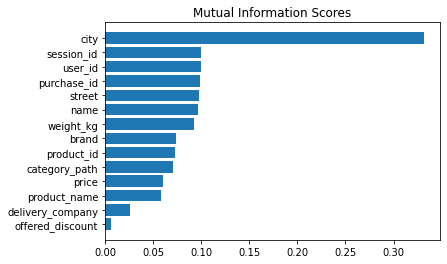

In [53]:
mi_scores = make_mi_scores(X, y, discrete_features)
plot_mi_scores(mi_scores)

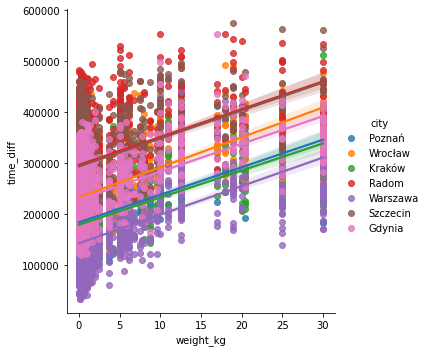

In [54]:
g = sns.lmplot(x='weight_kg', y='time_diff', hue='city', data=df)

# dropping columns (choosing attributes)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11315 entries, 0 to 11451
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   purchase_id          11315 non-null  int64         
 1   purchase_timestamp   11315 non-null  datetime64[ns]
 2   delivery_timestamp   11315 non-null  datetime64[ns]
 3   delivery_company     11315 non-null  int64         
 4   time_diff            11315 non-null  float64       
 5   session_id           11315 non-null  int64         
 6   user_id              11315 non-null  int64         
 7   product_id           11315 non-null  int64         
 8   event_type           11315 non-null  object        
 9   offered_discount     11315 non-null  int64         
 10  name                 11315 non-null  object        
 11  city                 11315 non-null  object        
 12  street               11315 non-null  object        
 13  product_name         11315 non-

In [56]:
# drop columns
df = df.drop(columns=COLUMNS_TO_DROP)
df = df.drop(columns="optional_attributes") # chyba do zmiany - wysokosc itp.
df = df.drop(columns="purchase_timestamp") # na pewno do zmiany

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11315 entries, 0 to 11451
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   delivery_company  11315 non-null  int64  
 1   time_diff         11315 non-null  float64
 2   offered_discount  11315 non-null  int64  
 3   city              11315 non-null  object 
 4   category_path     11315 non-null  object 
 5   price             11315 non-null  float64
 6   weight_kg         11315 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 707.2+ KB


# one-hot encoding

In [58]:
# df.to_excel("data_before_one_hot_encoding.xlsx")

In [59]:
def one_hot_encode_a_col_in_pd(df, col_name):
    one_hot = pd.get_dummies(df[col_name], drop_first=True)
    df = df.drop(columns=col_name)
    df = df.join(one_hot)
    return df

In [60]:
for col_name in COLUMNS_TO_ONE_HOT:
    df = one_hot_encode_a_col_in_pd(df, col_name)

#### checking df shape

In [61]:
print(df.shape)
columns_list = update_list_of_columns()
# ax = sns.heatmap(df[columns_list].corr(), square=True, cmap='RdYlGn')

(11315, 34)


In [62]:
df = df.dropna()
print(df.shape)
# one-hot encoding took care of missing data, so shape has not changed

(11315, 34)


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11315 entries, 0 to 11451
Data columns (total 34 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   time_diff                                      11315 non-null  float64
 1   offered_discount                               11315 non-null  int64  
 2   price                                          11315 non-null  float64
 3   weight_kg                                      11315 non-null  float64
 4   516                                            11315 non-null  uint8  
 5   620                                            11315 non-null  uint8  
 6   Kraków                                         11315 non-null  uint8  
 7   Poznań                                         11315 non-null  uint8  
 8   Radom                                          11315 non-null  uint8  
 9   Szczecin                                       113

# normalization

In [64]:
# specify columns for standardization scaling (Z-score normalization)
cols_to_std = []

# specify columns for min-max scaling
cols_to_min_max = ['offered_discount', 'price', 'weight_kg']

In [65]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

for col in cols_to_std:
    x = df[col].values
    std_scaler = StandardScaler()
    x_scaled = std_scaler.fit_transform(x.reshape(-1, 1))
    df[col] = x_scaled

for col in cols_to_min_max:
    x = df[col].values
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1, 1))
    df[col] = x_scaled

# test of linear regression models

In [66]:
df.head()

,time_diff,offered_discount,price,weight_kg,516,620,Kraków,Poznań,Radom,Szczecin,...,Myszki;Przewodowe,Pamięci przenośne;Pendrive,Podzespoły komputerowe;Pamięć RAM,Skanery;Profesjonalne,Skanery;Płaskie USB,Tablety;Urządzenia,Urządzenia VR;Gogle VR,Urządzenia wskazujące;Pady,Zestaw klawiatura i mysz;Bezprzewodowe,Zestaw klawiatura i mysz;Przewodowe
0,194397.0,0.75,0.228930,0.020000,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,184285.0,0.50,0.406238,0.000800,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,164705.0,0.00,0.665416,0.000000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,252885.0,0.75,0.448400,0.010667,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,228672.0,0.25,0.032173,0.008667,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def split_data(df, target_column="time_diff"):
    y = df["time_diff"].to_numpy()
    X = df.drop(columns="time_diff")
    return train_test_split(X, y, test_size=0.2, random_state=SEED)

In [68]:
def train_models(models_list):
    for model in models_list:
        model.fit(X_train, y_train)
    return models_list

In [69]:
def create_df_with_predictions(models_list, y_test):
    y_pred_df = pd.DataFrame()
    y_pred_df["y_test"] = y_test
    for model in models_list:
        y_pred_df[f"{type(model).__name__} prediction"] = model.predict(X_test)
    return y_pred_df

In [70]:
def display_predictions(y_pred_df):
    display(y_pred_df.head())
    display(y_pred_df.info())
    display(y_pred_df.describe())

In [71]:
def print_scores(models_list):
    for model in models_list:
        score = model.score(X_test, y_test)
        print(f"{type(model).__name__} score = {score}")

In [72]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


X_train, X_test, y_train, y_test = split_data(df)

models_list = [Ridge(alpha=0.1),
               Lasso(alpha=0.1),
               DecisionTreeRegressor(random_state=SEED),
               RandomForestRegressor(random_state=SEED)]
models_list = train_models(models_list)

y_pred_df = create_df_with_predictions(models_list, y_test)
display_predictions(y_pred_df)

print_scores(models_list)


,y_test,Ridge prediction,Lasso prediction,DecisionTreeRegressor prediction,RandomForestRegressor prediction
0,225013.0,290091.726175,290102.710763,237540.000000,240817.593333
1,170068.0,224600.455447,224587.072185,218666.333333,218477.638683
2,195038.0,220221.924393,220191.389560,209810.000000,224064.108167
3,279415.0,218870.036381,218707.291204,217214.000000,244879.800667
4,331221.0,314669.068454,314676.831787,293167.000000,319913.904000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   y_test                            2263 non-null   float64
 1   Ridge prediction                  2263 non-null   float64
 2   Lasso prediction                  2263 non-null   float64
 3   DecisionTreeRegressor prediction  2263 non-null   float64
 4   RandomForestRegressor prediction  2263 non-null   float64
dtypes: float64(5)
memory usage: 88.5 KB


None

,y_test,Ridge prediction,Lasso prediction,DecisionTreeRegressor prediction,RandomForestRegressor prediction
count,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000
mean,231077.817941,231586.990612,231589.883934,231920.942525,232430.228897
std,79705.119199,63129.122365,63150.348253,77977.231594,70834.337091
min,33091.000000,118759.945870,118765.804992,49657.000000,80762.975548
25%,174344.000000,179495.523856,179473.682055,175361.000000,180784.937250
50%,222482.000000,226963.099845,226796.009167,225631.000000,229358.910000
75%,281067.000000,282058.988473,282145.491699,277318.000000,272264.719833
max,535390.000000,455917.466845,456018.114477,563523.000000,513769.706333


Ridge score = 0.6104732608964016
Lasso score = 0.6105160773831061
DecisionTreeRegressor score = 0.4047764706664214
RandomForestRegressor score = 0.5890388901288853
